In [38]:
import torch
import numpy as np
import cupy as cp
import pyfftw
import matplotlib.pyplot as plt
import time


In [39]:
def torch_ifft_fft(data):
    signal_ndim = 2
    data2 = torch.fft(data, signal_ndim=signal_ndim)
    return torch.ifft(data2, signal_ndim=signal_ndim)

def np_ifft2_fft2(data):
    data2 = np.fft.fft2(data)
    return np.fft.ifft2(data2)

def cp_ifft2_fft2(data):
    data2 = cp.fft.fft2(data)
    return cp.fft.ifft2(data2)

def pyfftw_ifft2_fft2(data):
    data2 = pyfftw.interfaces.numpy_fft.fft2(data)
    return pyfftw.interfaces.numpy_fft.ifft2(data2)

In [40]:
sizes = [512, 1024, 2048, 4096] # X * X pixel arrays/tensors
names = []
totaltimes = []
name = 'PyTorch\nGPU'
device_type = 'cuda'
device = torch.device('cuda:{}'.format(0))
names.append(name)
print('{} available: {}'.format(name, torch.cuda.is_available()))
torchtimes = []
datas = [torch.randn(size=(x,x,2), device=device) for x in sizes]
print(f'Working on device: {datas[0].device}')
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    start = time.process_time()
    t = %timeit -o torch_ifft_fft(data)
    #torch_ifft_fft(data)
    #end = time.process_time()
    #t=end-start
    torchtimes.append(t)
totaltimes.append(torchtimes)

PyTorch
GPU available: True
Working on device: cuda:0
PyTorch GPU 512x512
287 µs ± 2.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
PyTorch GPU 1024x1024
1.11 ms ± 9.31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
PyTorch GPU 2048x2048
5.84 ms ± 74.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
PyTorch GPU 4096x4096
10.2 ms ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
name = 'Numpy\nCPU'
names.append(name)
nptimes = []
datas = [np.random.normal(size=(x,x)).astype('complex128') for x in sizes]
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o np_ifft2_fft2(data)
    nptimes.append(t)
totaltimes.append(nptimes)

Numpy CPU 512x512
42 ms ± 667 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numpy CPU 1024x1024
239 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy CPU 2048x2048
1.29 s ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy CPU 4096x4096
7.07 s ± 195 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
name = 'CuPy\nGPU'
names.append(name)
cptimes = []
device = cp.cuda.Device(0)
with device:
    datas = [cp.random.normal(size=(x,x)).astype('complex128') for x in sizes]
    for x, data in zip(sizes, datas):
        print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
        t = %timeit -o cp_ifft2_fft2(data)
        cptimes.append(t)
    totaltimes.append(cptimes)

OutOfMemoryError: out of memory to allocate 268435456 bytes (total 1048576000 bytes)

In [43]:
name = 'PyFFTW\nCPU'
names.append(name)
tensortimes = []
def pyfftw_array(shape):
    arr = pyfftw.empty_aligned(shape, dtype='complex128')
    arr[:] = np.random.normal(size=shape) + 1j*np.random.normal(size=shape)
    return arr
datas = [pyfftw_array((x,x)) for x in sizes]
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o pyfftw_ifft2_fft2(data)
    tensortimes.append(t)
totaltimes.append(tensortimes)

PyFFTW CPU 512x512
91 ms ± 756 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
PyFFTW CPU 1024x1024
628 ms ± 4.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
PyFFTW CPU 2048x2048
3.24 s ± 159 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
PyFFTW CPU 4096x4096
16.6 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Plotting results
Plot as function of data shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

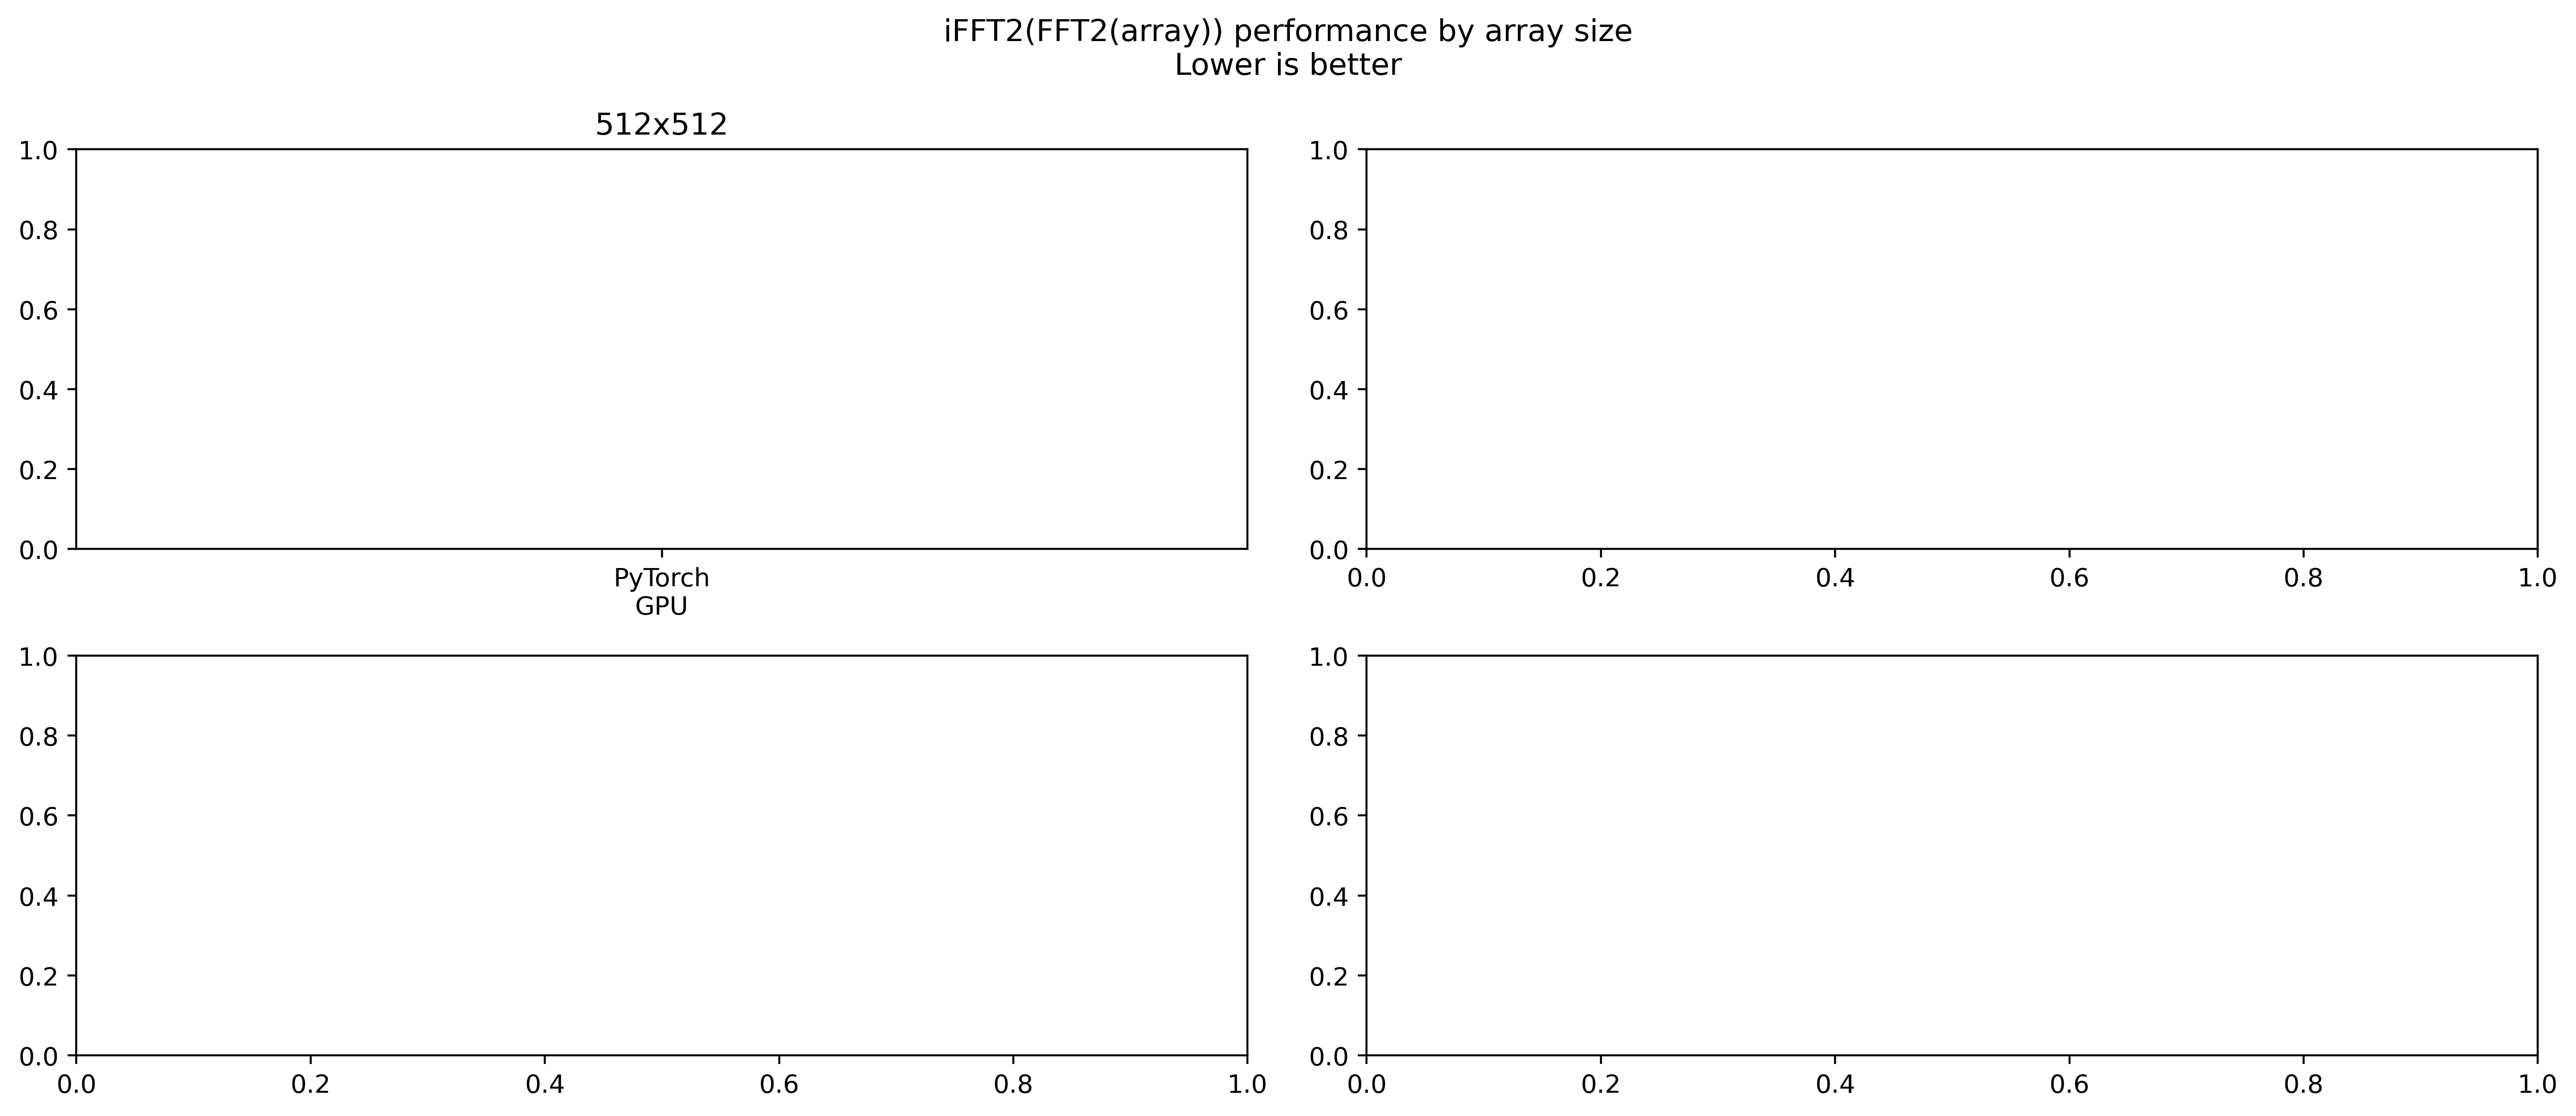

In [44]:
fig, AX = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(14,6), dpi=400)
# fig.canvas.layout.width = "1400px"
# fig.canvas.layout.height = "600px"
plt.suptitle('iFFT2(FFT2(array)) performance by array size\nLower is better')

for i in range(len(sizes)):
    t = np.array([time[i].average for time in totaltimes]) * 1000 # now in ms
    err = np.array([time[i].stdev for time in totaltimes]) * 1000
    ax = AX.flatten()[i]
    ax.set_title("{}x{}".format(sizes[i], sizes[i]))
    ax.bar(names, t)
    ax.set_yscale('log')
    ax.set_ylabel('FFT Time (ms)')
plt.savefig('FFT_Speed_by_size.png')

Average times (in ms) for a 4k x 4k array

In [45]:
times_4k = np.array([time[-1].average for time in totaltimes]) * 1000
for i in range(len(names)):
    print(" ".join(names[i].split('\n')))
    print(round(times_4k[i], 2))
    
pytorch_time_4k = times_4k[3] 
    
print()
print('4k x 4k iFFT2(FFT2())')
print('PyTorch faster than others by a factor of ')
times_4k = np.array([time[-1].average for time in totaltimes]) * 1000
for i in range(len(names)):
    print(" ".join(names[i].split('\n')))
    print(round(times_4k[i]/pytorch_time_4k, 2))

PyTorch GPU
10.22
Numpy CPU
7070.59
CuPy GPU
16608.11
PyFFTW CPU


IndexError: index 3 is out of bounds for axis 0 with size 3

Plot as function of software

IndexError: list index out of range

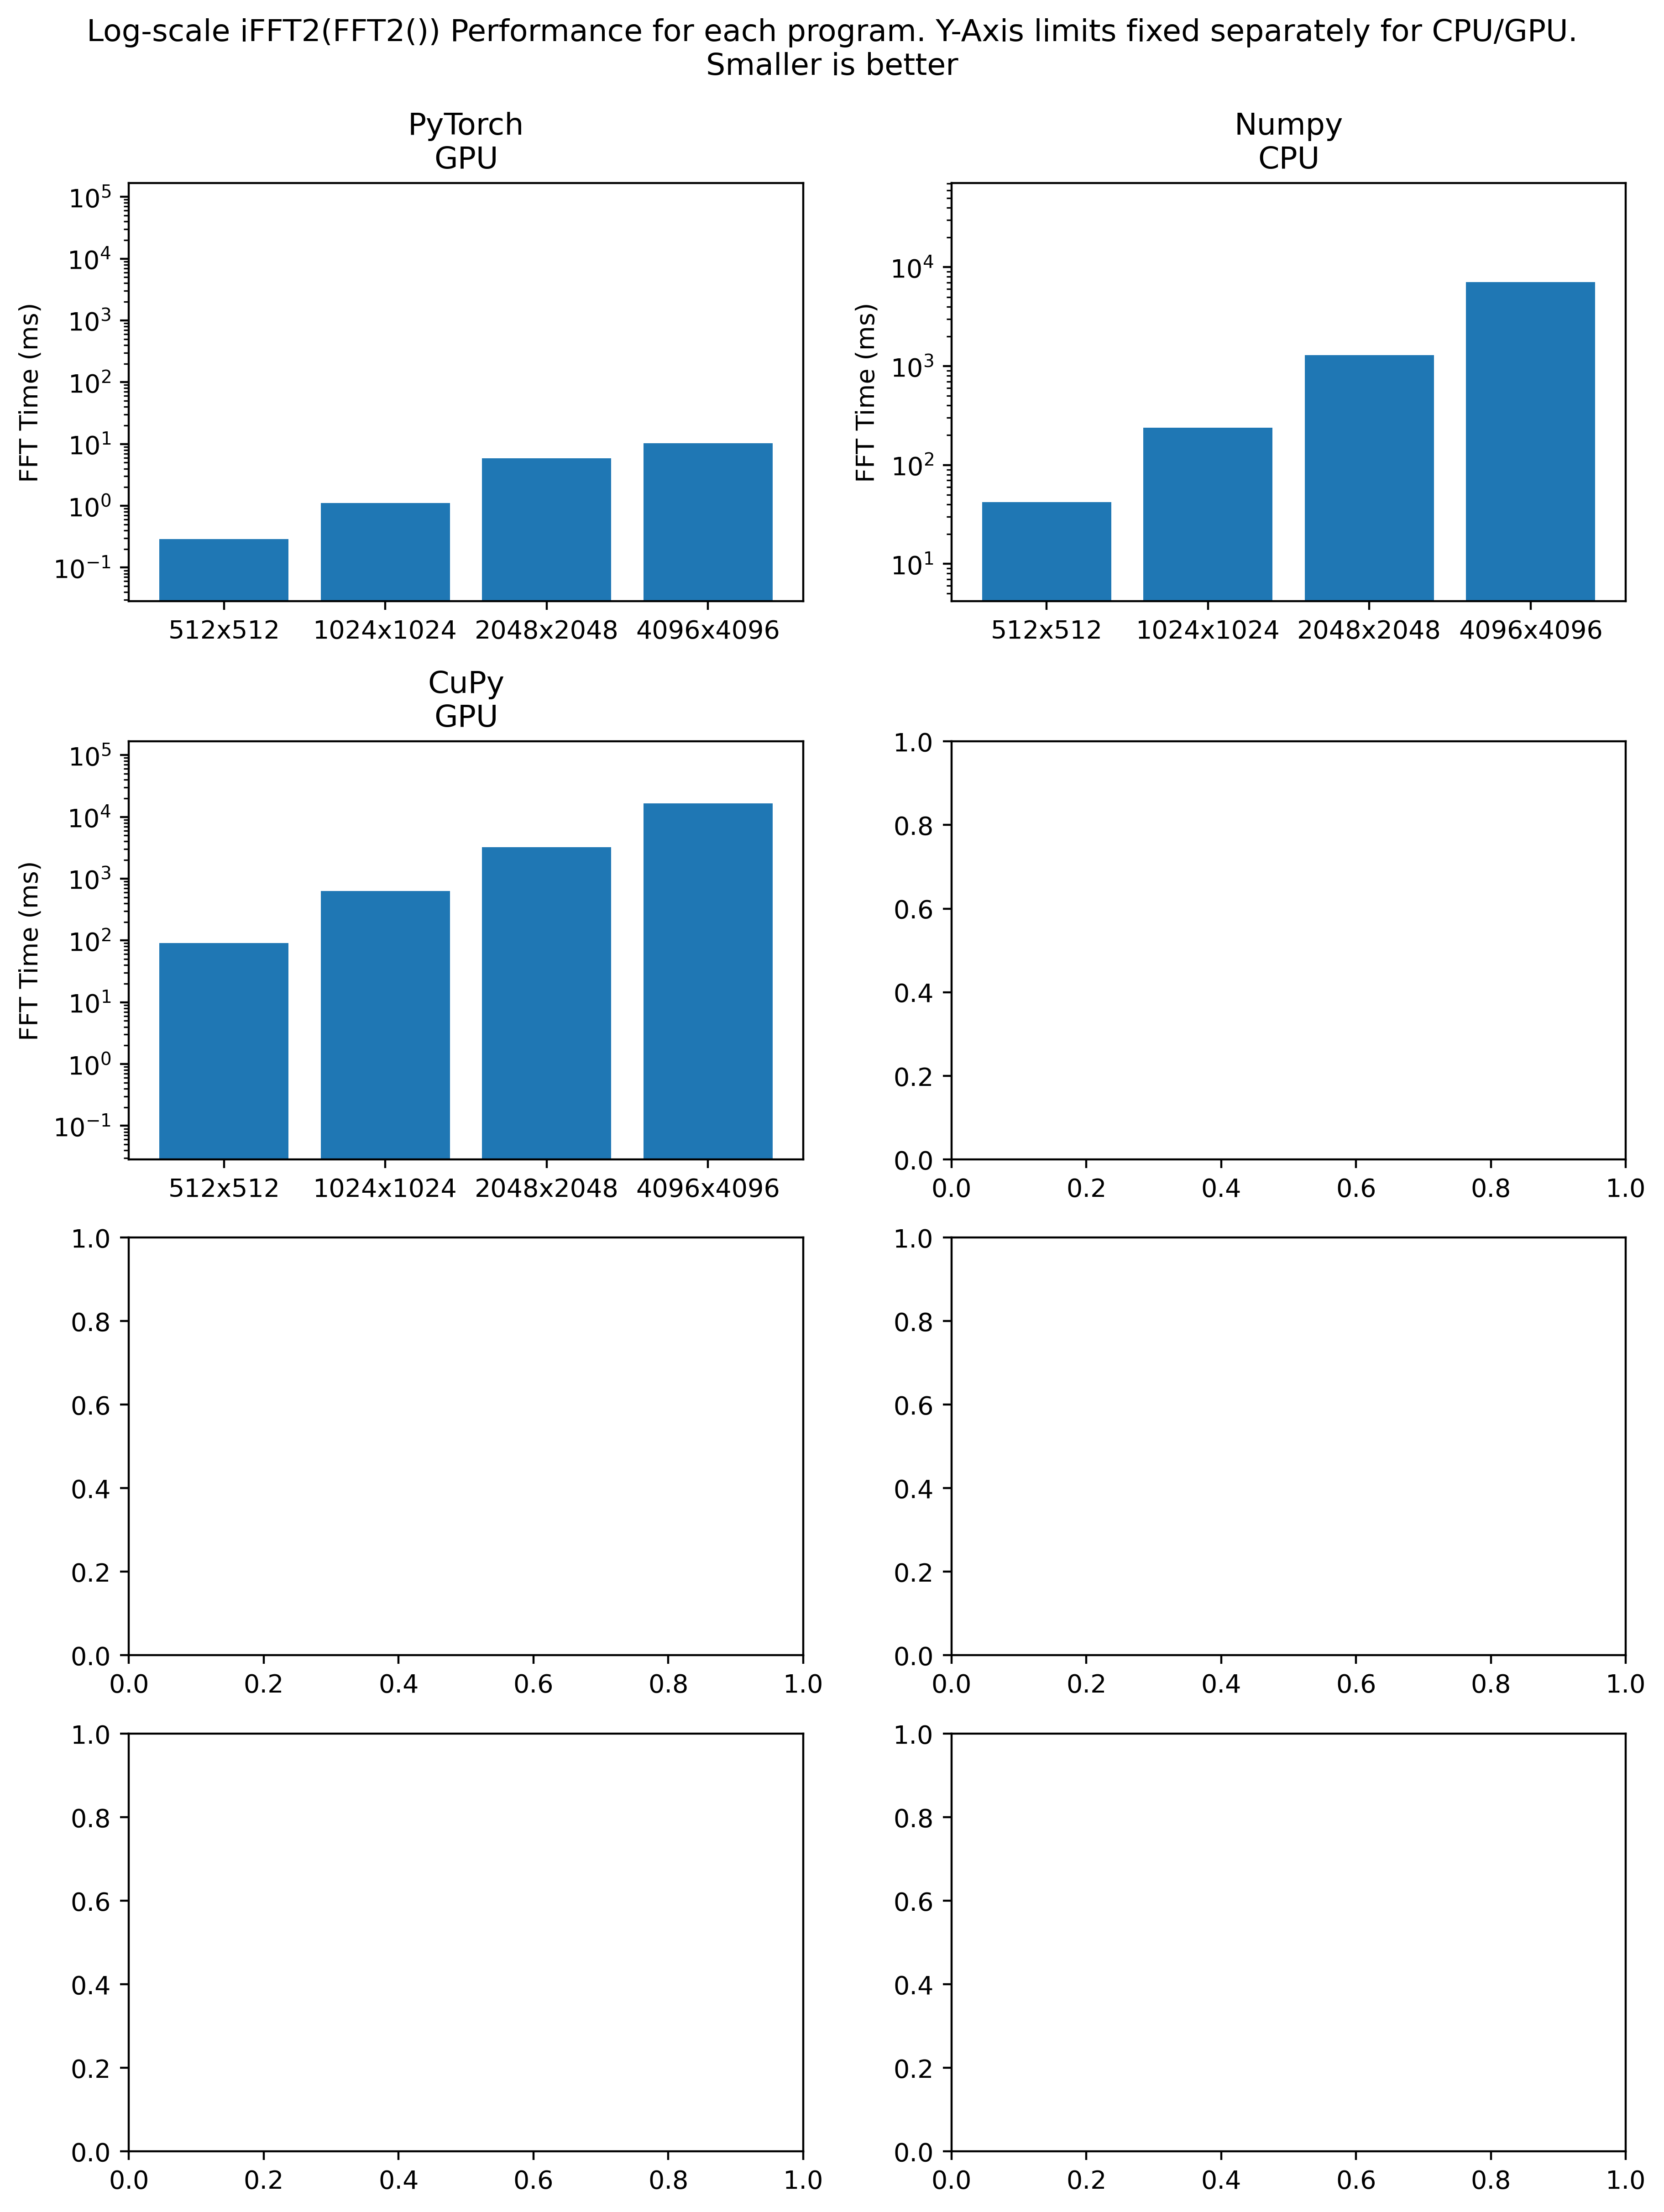

In [46]:
# Log scale
fig, AX = plt.subplots(ncols=2, nrows=4, constrained_layout=True, figsize=(9,12), dpi=400)
# fig.canvas.layout.width = "1300px"
# fig.canvas.layout.height = "1000px"
cputimes = [1000 * time.average for times in totaltimes[::2] for time in times]
gputimes = [1000 * time.average for times in totaltimes[1::2] for time in times]

gmx, gmn = max(gputimes), min(gputimes)
cmx, cmn = max(cputimes), min(cputimes)
plt.suptitle('Log-scale iFFT2(FFT2()) Performance for each program. Y-Axis limits fixed separately for CPU/GPU.\nSmaller is better')

for i in range(len(names)):
    t = np.array([time.average for time in totaltimes[i]]) * 1000 # now in ms
    ax = AX.flatten()[i]
    ax.set_title(names[i])
    sizes_title = ["{}x{}".format(size, size) for size in sizes]
    ax.bar(sizes_title, t)
    ax.set_yscale('log')
    if i % 2:
        ax.set_ylim(gmn/10, gmx*10)
    else:
        ax.set_ylim(cmn/10, cmx*10)
    ax.set_ylabel('FFT Time (ms)')
AX.flatten()[-1].remove()